# Predict Yelp Review Ratings (1 star - 5 star)


* Model: BERT uncased (fine tuned)


## Initialize model

In [1]:
from pytorch_transformers import BertForSequenceClassification, BertTokenizer

In [46]:
model = BertForSequenceClassification.from_pretrained("yelp-bert-model", 
                                                      num_labels=5,
                                                      output_hidden_states=True)

In [3]:
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

## Review Vectorizer

In [4]:
def to_features(df, tokenizer, max_seq_length=256):
    features = {'all_token_ids' : [],
                'all_input_mask' : [],
                'all_segment_ids' : [],
                'all_label_ids' : []}
    
    for row in df.itertuples():
        # tokenize + index tokens
        if hasattr(row,'bert_tokens'):
            token_ids = row.bert_tokens
        else:
            token_ids = tokenizer.encode(row.review)
            
        if len(token_ids) > max_seq_length-2:
            desired_length = max_seq_length-2
            # one fourth of the tokens from the head
            head_len = int(desired_length/4)
            # remaining three fourth from the tail
            tail_len = int(3*desired_length/4)
            token_ids = token_ids[:head_len] + token_ids[-tail_len:]
        token_ids = tokenizer.encode(tokenizer.cls_token) + \
                    token_ids + \
                    tokenizer.encode(tokenizer.sep_token)
        input_mask = [1] * len(token_ids)
        segment_ids = [0] * len(token_ids)
        
        # pad upto max_seq_length
        padding_length = max_seq_length - len(token_ids)
        pad_token_id_list = tokenizer.encode(tokenizer.pad_token)
        
        token_ids += pad_token_id_list * padding_length
        input_mask += pad_token_id_list * padding_length
        segment_ids += pad_token_id_list * padding_length
        
        assert len(token_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        features['all_token_ids'].append(token_ids)
        features['all_input_mask'].append(input_mask)
        features['all_segment_ids'].append(segment_ids)
        
        if hasattr(row,'rating'):
            features['all_label_ids'].append(row.rating-1)
        
    return features

## Rating Prediction

In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
def predict_rating(review):
    model.eval()
    
    one_df = pd.DataFrame(data=[(review,)], columns=['review'])
    eval_features = to_features(one_df, tokenizer)
    eval_dataset = TensorDataset(torch.tensor(eval_features['all_token_ids']),
                        torch.tensor(eval_features['all_input_mask']),
                        torch.tensor(eval_features['all_segment_ids']),
                       )
    batch = eval_dataset.tensors
    batch = tuple(t.to(device) for t in batch)
    
    model.eval()
    with torch.no_grad():
        inputs = {'input_ids' : batch[0],
              'attention_mask' : batch[1],
              'token_type_ids' : batch[2],
             }
        outputs = model(**inputs)
        logits = outputs[0]
        
    preds = logits.detach().cpu().numpy()
    preds = np.argmax(preds, axis=1)
    return preds[0]+1

## Load Yelp Reviews (df contains test set)

In [8]:
%config InlineBackend.figure_format = 'retina'

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
pd.options.display.max_colwidth=-1

In [11]:
df = pd.read_csv("../yelp_review_full_csv/test.csv", header=None, names=['rating', 'review'])

In [12]:
np.random.seed(42)

In [13]:
sample_df = df.groupby('rating',group_keys=False).apply(lambda g:g.sample(2))

In [14]:
sample_df

,rating,review
32328,1,"If you are a human being and thus may at some point after midnight need to pee or poop, don't eat here. The restaurant is open until 3 or 4 a.m. and is quite willing to take your money and serve you food and biiiiiiiiig giant sodas, but beware...their restroom closes at midnight. \n\nI couldn't believe that as a customer, eating in, I was not allowed to use the restroom. Is that even legal?? \n\nI asked where customers were expected to use the restroom after eating and drinking at their establishment. The girl informed me that customers can go \""next door to Fat Tuesday\"". \nThere are 2 MAJOR issues with that:\n1 - you can't get into Fat Tuesday (a bar) if you aren't 21, so late night 20 year old sandwich eaters better have big ass bladders.\n2 - the line to get into Fat Tuesday is sometimes about 20 people long, then once you get carded, get inside, and navigate through the crowd, the bathroom line for the ladies room is another 10-15 long. This means if you leave Jimmy Johns in the middle of eating to pee, you must be 21+ and you will be gone for 20 minutes to an hour to take a leak next door. You can then come back to your crusty sandwich and your annoyed friends who have been babysitting your food while you went pee pee partying over at Tuesdays. Screw that.\n\nI'll tell you right now, if I were a guy, I seriously would've pissed on their floor under my table. But...as a girl, that could be messy for me. So...lucky for you Jimmy Johns...I was born without a penis. You win the prize of no pee on your floor, but you will never win my business EVER again."
48344,1,"Is it possible to rate an establishment with less than 1 star? The security team here is a joke. I came in with a pocket knife (I am a woman mind you) only to have it confiscated at the door. This wasn't too much to ask as I understand the need for a safe environment. I do want to make it known that I carry my pocket knife everywhere and have never had it confiscated at any of the bars on Fremont. I forgot to get it back that night but came back the next day to grab it. \n\nThe only person that was available to talk was the barista that worked the counter at the coffee shop. She informed me that the knife was potbelly locked away in a safe because she couldn't find it. She took down my information and told me she would call once my knife was found. She called me with in a few hours to let me know my knife was there and safe. I was unable to come on Saturday night because I had to work. I came back on Sunday and Monday during the day and found the establishment closed on both of hose days. Because I work and go to school full time, tonight was the first day I could come back. \n\nI was greeted by security and waited for about 15 minutes for the manager to come from upstairs to open the safe that my knife was supposedly kept in. After waiting for the manger for 15 minutes, the manager informs me that there was in fact no knife in the safe. This left me very confused. After gathering my thoughts and confusion, approached the manager with my question about the whereabouts of my pocket knife. After a few minutes the director of security became involved. The director went on to ask me why they would even bother putting someone's knife in safe to begin with. I was just as confused about that as he was. I went on to ask him why several people would tell me that my property was put in a safe and why the where about of my property we're know one day and unknown the next. I also asked his if he was concerned about his employees taking property from customers, specifically weapons. \n\nBoth gentlemen were unconcerned with the fact that a weapon was missing and that a customer was very unhappy with losing property at their establishment. Both of these gentlemen need to be taught a few lessons on how to talk and deal with customers. I am very upset and am looking into how I can get this resolved. This security team is very unprofessional in every way po

In [15]:
for row in sample_df.itertuples():
  print(row.Index, row.rating, predict_rating(row.review))

Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


32328 1 1
48344 1 1
43089 2 2
38033 2 2
21419 3 4
7434 3 5
42688 4 4
8947 4 4
5825 5 5
10016 5 5


## Rule based sentiment analysis (Vader)

Typical threshold values:

* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05

* The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [17]:
analyzer = SentimentIntensityAnalyzer()

In [18]:
def get_compound_score(review):
  return analyzer.polarity_scores(review)['compound']

In [19]:
for row in sample_df.itertuples():
  print(f"""{row.Index}, {row.rating} => 
            Model: {predict_rating(row.review)}, Rule: {get_compound_score(row.review)}""")

Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


32328, 1 => 
            Model: 1, Rule: -0.9585
48344, 1 => 
            Model: 1, Rule: -0.8829
43089, 2 => 
            Model: 2, Rule: 0.5312
38033, 2 => 
            Model: 2, Rule: -0.9491
21419, 3 => 
            Model: 4, Rule: 0.9882
7434, 3 => 
            Model: 5, Rule: 0.7955
42688, 4 => 
            Model: 4, Rule: 0.8547
8947, 4 => 
            Model: 4, Rule: 0.9866
5825, 5 => 
            Model: 5, Rule: 0.6369
10016, 5 => 
            Model: 5, Rule: 0.9955


In [55]:
get_compound_score(df.iloc[24807].review) # 24807

-0.5393

In [20]:
df['compound_score'] = df.review.apply(get_compound_score)

In [27]:
df['review_len'] = df.review.str.len()

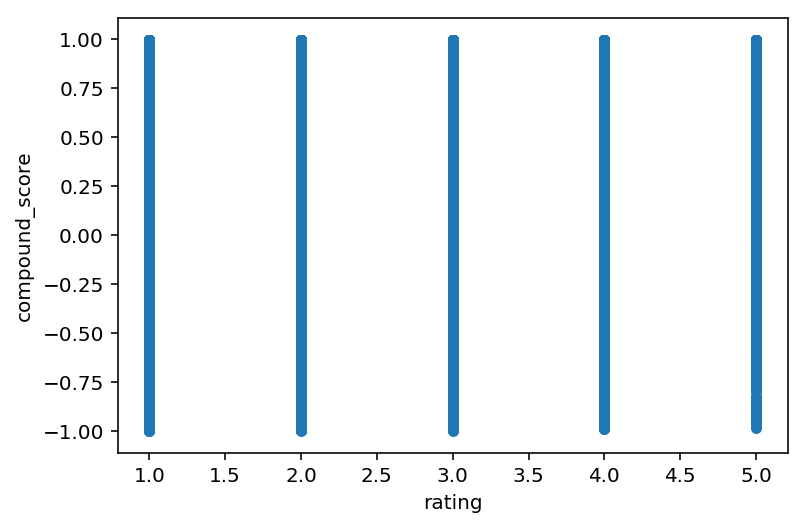

In [28]:
df.plot.scatter('rating', 'compound_score');

In [29]:
df[(df.rating==5) & (df.compound_score <= -0.9)].sort_values('review_len').head(5)

,rating,review,compound_score,review_len
47338,5,Hervoragender yufka auch der XXl.. k\u00f6nnte insgesamt aber auch etwas billiger sein. hab auch die pizza die dort aus einem holzofen kommt probiert und auch die pide ist einfach vorz\u00fcglich. das personal ist immer nett und gut drauf.\neinzigstes manko das ich aber verkraften kann ist das es dort kein bier gibt.,-0.9136,318
8605,5,"Eating here almost made me feel like i was back in the bay area! Upon walking in, i remember my co-workers exclaiming in excitement,\n\""There are other ASIANS HERE! WOH! You even pay at the register!\"" \n\nThat's authenticity roite thar.\n\nI didn't think that i would be able to find an authentic asian restaurant in the phoenix area but this place proved me wrong. Not the best pho ever, but the best by far that i found in the area.",-0.9420,435
35985,5,"Wir waren hier bereits 3 mal mit Freunden drin. Der Barkeeper hatte sich die Zeit genommen und sich zu uns gesetzt. Nach einem netten Plausch, habe ich mir einen Cocktail empfehlen lassen. Ich wei\u00df nicht mehr was alles drin war und auf der Karte war der Cocktail auch nicht aber lecker war er.\nDas Ambiente ist wirklich angenehm und absolut nicht snobig oder spie\u00dfig. Es ist sehr leger. Man braucht nicht mit Hemd und Kragen kommen\nWir kommen definitiv wieder. Weiters so.",-0.9485,485
119,5,"Stopped by with my laptop late last Friday afternoon to enjoy some craft brews and prep for a class I'm teaching Saturday morning. Normally I have nothing but great things to say about Mad Mex in Scott Town Center, but I was mildly annoyed by a new server who seemed to abandon me after finding out I wished to stay and work after purchasing my meal and buying several craft brews. This is not the normal treatment at this establishment for the guy at table #28 with the laptop. In any case, great food & great selection of microbrews!",-0.9788,538
47346,5,"Klein aber fein. Wirklich viel Platz bietet das Ohne Gleichen nicht, daf\u00fcr ist es dann um so gem\u00fctlicher wenn man denn einen Sitzplatz abbekommen hat.\n\n\n Die Inneneinrichtung ist spitze und bietet einen modernen Kontrast zur hohen Stuckdecke. Von den den Raum umrandenden roten Sitzb\u00e4nken sollte man sich allerdings nicht t\u00e4uschen lassen - die sind l\u00e4ngst nicht so weich wie sie aussehen. Eigentlich sind sie n\u00e4mlich gar nicht gepolstert. Und ein gepflegtes in die Kissen fallen f\u00fchrt so recht flott zu blauen Flecken am allerwertesten.\n\n\n Daf\u00fcr sind die Bedienungen sehr locker und zuvorkommend. Die Preise sind in Ordnung.",-0.9719,670


## Demo

In [48]:
# 13310
review = """Great ambience but the food doesn't cut it. 
The only thing that was pod was the free dinner rolls that were buttery and had sea salt on top to offset 
the sweetness. 
Got the $55 ribeye that came luke warm and under seasoned. By far the worst ribeye I've ever 
had at a nice steakhouse. It was full of fat too.

The risotto was horrible. Sour like something we bad and it came with huge cherry tomatoes, very unrefined.

Short rib was delicious, highly recommended. 
Scallops were just whatever and the carpaccio was good, savory and worth trying.

Service was excellent minus out main server. He didn't do much but the other help was amazing.
Monkey bread was recommended so we tried it. Very very very sweet, too sweet. 
I y thing that was good was the banana ice cream but I wouldn't get this of you for 
like your deserts too sweet.

Overall, it was a bad steakhouse. Skip it"""

In [49]:
predict_rating(review)

2

In [50]:
# scale of -1 to 1
get_compound_score(review)

0.996

In [51]:
# 119
review = """Stopped by with my laptop late last Friday afternoon to enjoy some craft brews and 
prep for a class I'm teaching Saturday morning. Normally I have nothing but great things to say 
about Mad Mex in Scott Town Center, but I was mildly annoyed by a new server who seemed to 
abandon me after finding out I wished to stay and work after purchasing my meal 
and buying several craft brews. This is not the normal treatment at this establishment 
for the guy at table #28 with the laptop. 
In any case, great food & great selection of microbrews!"""

In [52]:
predict_rating(review)

4

In [53]:
get_compound_score(review)

-0.9788

## Visualization

In [40]:
np.random.seed(42)
vis_df = df.sample(n=20000)
vis_features = to_features(vis_df, tokenizer)
vis_dataset = TensorDataset(torch.tensor(vis_features['all_token_ids']),
                        torch.tensor(vis_features['all_input_mask']),
                        torch.tensor(vis_features['all_segment_ids']),
                        torch.tensor(vis_features['all_label_ids'])
                       )

Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (632 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1027 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (866 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (990 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (970 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (958 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (857 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (965 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (864 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (675 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1110 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (863 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (643 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (866 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1015 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (710 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (898 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (675 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (663 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (644 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (964 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1120 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1129 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (619 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (729 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (864 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (783 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1002 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (841 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (724 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (855 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (724 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [41]:
batch_size = 20
vis_sampler = SequentialSampler(vis_dataset)
vis_dataloader = DataLoader(vis_dataset, sampler=vis_sampler, batch_size=batch_size)

In [44]:
from tqdm import tqdm

In [55]:
all_vecs = []
labels = []
for batch in tqdm(vis_dataloader, desc="Embedding"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids' : batch[0],
                      'attention_mask' : batch[1],
                      'token_type_ids' : batch[2],
                      'labels' : batch[3]
                 }
        outputs = model(**inputs)
        loss, logits, all_hidden_states = outputs
        mask = batch[1].unsqueeze(dim=2).float()
        batch_vecs = torch.empty(batch_size,768,13)
        for layer_idx in range(len(all_hidden_states)):
            emb_vec = all_hidden_states[layer_idx]
            emb_vec = (emb_vec*mask).sum(dim=1)/(mask.sum(dim=1)+1e-10)
            batch_vecs[:,:,layer_idx] = emb_vec
            
        all_vecs.append(batch_vecs)
        labels.append(batch[3])

Embedding:   1%|          | 6/1000 [00:48<2:15:24,  8.17s/it]

KeyboardInterrupt: 